## __策略思想__
---
* #### 采用Markowitz均值方差模型对于分散化的资产(ETF基金)进行配仓  
    * ##### 采用动态信息更新协方差矩阵与收益向量
    * ##### 为避免资产过于集中带来风险，设置单个资产仓位不超过30%的约束
    * ##### 即：


$$\max({u'*w}-{\lambda/2*w'*\Sigma*w})$$


$$\sum w = 1$$

$$0 \leq w \leq 0.3$$
##### 上式中：$u$为资产的预期收益率，$w$为资产权重，$\lambda$为投资者风险厌恶系数，$\Sigma$为方差协方差矩阵  


</br>
* #### 采用Larry Swedroe的5/25方法动态确认调仓频率，即：

	* ##### 1) 当某个资产的position变动超过5%,做一次rebalance
	* ##### 2) 当某个资产相对于自身原始仓位变动超过25%,做一次rebalance
    
## __结论__
---
* ##### 设定大风险厌恶系数时，Markowitz配仓方法能够实现稳定的高收益

* ##### 最大回撤5.8%，波动率7.9%，并且年化收益达到16.8%；调仓少、幅度小，看来有相当的可操作性



</br>
注：关于Markowitz均值方差模型更加详细的介绍可以看[量化分析师的Python日记【第15天：如何在优矿上搞一个wealthfront出来】](https://uqer.io/community/share/5670da3c228e5b8d81f00a87)

## __回测情况__
---

In [ ]:
# 引入工具包
from __future__ import division
from cvxopt import matrix, solvers
from CAL.PyCAL import *
# from lib.lib import *
import scipy.stats as st


import collections
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('white')

DataAPI.settings.cache_enabled = True
pd.options.display.max_colwidth = 1000

* ##### 用到的一些ETF如下，包含世界范围内的多类资产：

In [ ]:
DataAPI.FundGet(secID = ['159915.XSHE', '160216.XSHE', '510050.XSHG', 
                '510300.XSHG','510500.XSHG', '511010.XSHG', '511880.XSHG', '513100.XSHG', '513500.XSHG', '518880.XSHG'], 
                field = 'secID,secShortName,listDate,category').set_index('secID').sort('category').T

secID,511010.XSHG,159915.XSHE,510050.XSHG,510300.XSHG,510500.XSHG,513100.XSHG,513500.XSHG,511880.XSHG,160216.XSHE,518880.XSHG
secShortName,国泰上证5年期国债ETF,易方达创业板ETF,华夏上证50ETF,华泰柏瑞沪深300ETF,南方中证500ETF,国泰纳斯达克100ETF(QDII),博时标普500ETF(QDII),银华货币ETF-A,国泰大宗商品配置(QDII-LOF),华安易富黄金ETF
listDate,2013-03-25,2011-12-09,2005-02-23,2012-05-28,2013-03-15,2013-05-15,2014-01-15,2013-04-18,2015-04-07,2013-07-29
category,B,E,E,E,E,E,E,M,O,O


In [ ]:
def markowitz(cov_mat, exp_rtn, risk_aversion = 3, single_asset_capacity = 0.2):
    
    P = risk_aversion * matrix(cov_mat.values)
    q = -1 * matrix(exp_rtn.values)
    G = matrix(np.vstack((np.diag(np.ones(len(exp_rtn))),np.diag(-np.ones(len(exp_rtn))))))
    h = matrix(np.array([np.ones(len(exp_rtn)) * single_asset_capacity, np.zeros(len(exp_rtn))]).reshape(len(exp_rtn)*2,1))
    A = matrix(np.ones(len(exp_rtn)),(1,len(exp_rtn)))
    b = matrix([1.0])
    solvers.options['show_progress'] = False
    sol = solvers.qp(P,q, G, h, A, b)
    return sol, pd.DataFrame(index=exp_rtn.index,data = np.round(sol['x'],3), columns = ['weight'])

* ##### 在`2014-01-01 ～ 2016-08-29`期间进行回测，效果看起来不错

* ##### 概览回测期间持仓情况，可见2014年底有一次大幅换仓，之前主要持有美股ETF；之后黄金ETF与债券ETF比例有所提升。

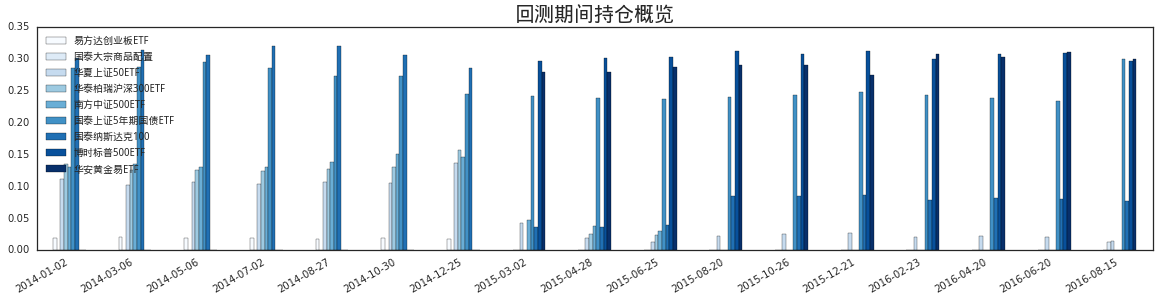

In [ ]:
res = {}
for x,date in enumerate(bt.tradeDate):
    new_bt = bt.set_index('tradeDate')
    res[date] = new_bt.security_position[x]
    
res = pd.Panel(res)

fig = (res.major_xs('value').fillna(0) / new_bt.portfolio_value).T[::40].plot(kind = 'bar', figsize = (20,4), cmap = plt.cm.Blues)
plt.legend(
    map(lambda x: x.decode('utf-8'), DataAPI.FundGet(secID = res.major_xs('value').index, field = 'secShortName').secShortName), 
    prop = font, loc = 2)
fig.set_xticklabels(map(lambda x: x.strftime('%Y-%m-%d') ,(res.major_xs('value').fillna(0) / new_bt.portfolio_value).T[::40].index), 
                    rotation = 30, ha = 'right')
plt.title(u'回测期间持仓概览', fontproperties = font, fontsize = 20)
plt.show()